# ECS759P Lab4 - Evolutionary Algorithms

## Recap

Last time we went through examples of **informed** and **local** search algorithms. In this lab, we will deal with the features and problems shared by most evolutionary algorithms. You will then practice implementing a Genetic Algorithm to solve the Traveling Salesperson Problem (TSP) problem from scratch.

We will then use the Distributed Evolutionary Algorithms in Python (DEAP) library to build such algorithms. You will need to refer to the [DEAP API documentation](https://deap.readthedocs.io/en/master/api/).

# 0. Elements to take into account using evolutionary algorithms


- **Individual representation** (binary, Gray, floating-point, etc.);
- **Evaluation and fitness assignment**;
- **Mating selection**: that establishes a partial order of individuals in the population using their fitness function value as reference and determines the degree at which individuals in the population will take part in the generation of new (offspring) individuals.
- **Variation**: this applies a range of evolution-inspired operators, like crossover, mutation, etc., to synthesise offspring individuals from the current (parent) population. This process is supposed to prime the fittest individuals so that they play a bigger role in the generation of the offspring.
- **Environmental selection**: that merges the parent and offspring individuals to produce the population that will be used in the next iteration. This process often involves the deletion of some individuals using a given criterion in order to keep the amount of individuals bellow a certain threshold.
- **Stopping criterion**: that determines when the algorithm should be stopped, either because the optimum was reach or because the optimisation process is not progressing.

## Hence a 'general' evolutionary algorithm can be described as

In [254]:
def evolutionary_algorithm():
    'Pseudocode of an evolutionary algorithm'
    populations = [] # a list with all the populations

    populations[0] =  initialize_population(pop_size)
    t = 0

    while not stop_criterion(populations[t]):
        fitnesses = evaluate(populations[t])
        offspring = mating_and_variation(populations[t], fitnesses)
        populations[t+1] = environmental_selection(populations[t], offspring)
        t = t+1

# 1. Using Genetic Algorithms to solve the Traveling Salesperson Problem

### Traveling Salesperson Problem (TSP)

_Given a set of cities, and the distances between each pair of cities, find a tour of the cities with the minimum total distance. A tour means you start at one city, visit every other city exactly once, and then return to the starting city._

- This is a well-known intractable problem, meaning that there are no efficient solutions that work for a large number of cities
- We can create an inefficient algorithm that works fine for a small number of cites (about a dozen)
- We can also find a nearly-shortest tour over thousands of cities
- Actually, the fact there is no efficient algorithm is liberating. This means that we can use a very simple, inefficient algorithm and not feel too bad about it :)

The vocabulary of the problem:

- City: For the purpose of this lab, a city is "atomic" in the sense that we do not have to know anything about the components or attributes of a city, just how far it is from other cities
- Cities: We will need to represent a set of cities; Python's `set` datatype might be appropriate for that.
- Distance: We will need the distance between two cities. If A and B are cities. This could be done with a function, `distance(A, B)`, or with a `dict`, `distance[A][B]` or `distance[A, B]`, or with an array if `A` and `B` are integer indexes. The resulting distance will be a real number (which Python calls a `float`).
- Tour: A tour is an ordered list of cities; Python's `list` or `tuple` datatypes would work.
- Total distance: The sum of the distances of adjacent cities in the tour. We will probably have a function, `total_distance(tour)`.

In [255]:
import random, operator, time, itertools, math, copy
import numpy as np

# useful for visualization
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from matplotlib import rc
rc("text", usetex=False)

import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

### Representing Tours
- A tour starts in one city, and then visits each of the other cities in order, before finally returning to the starting city
- A natural representation of the set of available cities is a Python set, and a natural representation of a tour is a sequence that is a _permutation_ of the set
- The tuple `(1, 2, 3)`, for example, represents a tour that starts in city 1, moves to 2, then 3, and then returns to 1 to finish the tour

In [256]:
# Permutation function is already defined in the itertools module
alltours = itertools.permutations
cities = {1, 2, 3}
list(alltours(cities))

[(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]

**Q. By filling the gaps below, implement the necessary functions.**

In [257]:
# The difference between the points a + bj and s + tj in the complex plane is d= math.sqrt((s−a)**2+(t−b)**2).

def distance(A, B):
    # TO DO
    "The Euclidean distance between two cities."
    return abs(A - B)
    # TO DO

### Representing Cities and Distance
Now for the notion of _distance_. We define `total_distance(tour)` as the sum of the distances between consecutive cities in the tour; that part is shown below and is easy (with one Python-specific trick: when `i` is 0, then `distance(tour[0], tour[-1])` gives us the wrap-around distance between the first and last cities, because `tour[-1]` is the last element of `tour`).

In [258]:
def total_distance(tour):
    "The total distance between each pair of consecutive cities in the tour"
    return sum(distance(tour[i], tour[i-1]) for i in range(len(tour)))

### Distance between cities
Before we can define `distance(A, B)`, the distance between two cities, we have to make a choice. In the fully general version of the TSP problem, the distance between two cities could be anything: it could be the amount of time or money it takes to travel between cities.

We will we represent a two-dimensional point with the `complex`, built-in numeric data type for two-dimensional points. We will define `City = complex`, meaning that we construct the representation of a city using the same constructor that makes complex numbers.

In [259]:
City = complex # Constructor for new cities, e.g. City(300, 400)

In [260]:
A = City(300, 0)
B = City(0, 400)
distance(A, B)

500.0

In [261]:
def generate_cities(n):
    "Make a set of n cities, each with random coordinates."
    "E.g., x coordinate between (10, 890) and y coordinate between (10, 590)"
    # TO DO
    return set(City(random.randrange(10, 890), random.randrange(10, 590)) for c in range(n))
    # TO DO

In [262]:
# Let's try some examples
cities8, cities10, cities100, cities1000 = generate_cities(8), generate_cities(10), generate_cities(100), generate_cities(1000)
# print out one for sanity check
cities8

{(113+299j),
 (138+278j),
 (145+202j),
 (16+558j),
 (254+581j),
 (517+93j),
 (642+46j),
 (687+246j)}

### Genetic Algorithm from Scratch

We will follow the basic steps for a genetic algorithm and attempt to solve the TSP problem from scratch: initialise a population, take the best half of it for mating, perform crossing over and mutation with pre-set probabilities (hyperparameters), combine the best parents with the offspring to form the next population.  

**Q. By filling the gaps below, implement a genetic algorithm to solve our TSP problem with 30 cities. Think about a suitable mutation operation. When implementing cross-over, pay attention to the fact that in the TSP problem permutations of cities contain no repetitions.**

In [263]:
def create_init_population(pop_size, city_dict):
    '''
    Method to create initial population
    '''
    population = []
    cities_list = copy.deepcopy(list(city_dict.keys()))

    for i in range(0, pop_size):

        # We create permutations by random shuffling
        random.shuffle(cities_list)
        population.append(copy.deepcopy(cities_list))

    return population

In [264]:
def mutation(pool_to_mutate, pMuta = 0.5):
  """
  Mutate provided individuals with pMuta probability
  """
  for index, indiv in enumerate(pool_to_mutate):
    for pos in range(len(indiv)):
      # TO DO
      if np.random.rand() <= pMuta:
        # pick a random position to swap with
        pos2 = random.sample(range(len(indiv)), 1)[0]
        # swap the positions
        temp_val = indiv[pos]
        indiv[pos] = indiv[pos2]
        indiv[pos2] = temp_val
      # TO DO
  return pool_to_mutate

def crossing_over(pool_to_cross, pCO = 0.1):
  """
  Applies crossing over on the selected individuals with a probability pCO
  """
  
  for index, indiv in enumerate(pool_to_cross):
    # TO DO
    # If crossing over should be applied on this individual for the given crossover rate
    if np.random.rand() <= pCO:
      # We get the list of all the other selected individuals
      others = pool_to_cross[:]
      others.remove(indiv)
      # We pick randomly one of them
      other = others[np.random.choice(len(others))]
      # We get its index in order to modify it directly
      otherIdx = pool_to_cross.index(other)
      # Randomly choose a starting point and
      # then we swap the genome starting from that position
      # between the two individuals
      startingIdx = np.random.choice(len(indiv))
      tempChange = indiv[startingIdx:]

      # we check if the permutation property is preserved
      # (i.e., cities will not be repeated after cross-over)
      if not any(city in indiv[:startingIdx] for city in other[startingIdx:]):

        indiv[startingIdx:], other[startingIdx:] = other[startingIdx:], tempChange
        # Modification of the new one
        pool_to_cross[otherIdx] = other
        pool_to_cross[index] = indiv

    # TO DO
  return pool_to_cross

In [265]:
def sort_individuals(pool_to_sort, city_dict):

  # We get fitness values for each individual by using the total distance method above
  fitness_values = [total_distance([city_dict[city] for city in i]) for i in pool_to_sort]
  sorted_pairs = sorted(zip(fitness_values, pool_to_sort))
  pool_to_sort = [item[1] for item in sorted_pairs]
  return pool_to_sort


In [266]:
# Number of cities in our problem
num_cities = 30
# Population size
pop_size = 300
half = int(pop_size / 2)
# Mutation rate (per gene)
pMuta = 0.2
# Crossover rate
pCO = 0.8
# Number of generations
n_gen = 400

# Get the list of city coordinates
cities = list(generate_cities(num_cities))
print(cities)
# City position in the list will be its name
# E.g., for two cities we will get the following dictionary {'0': (116+327j), '1': (779+536j)}
city_dict = {str(i): cities[i] for i in range(len(cities))}

# Create initial population via permutations
population = create_init_population(pop_size, city_dict)
population = sort_individuals(population, city_dict)

print("Best initial population result has a fitness of " + str(total_distance([city_dict[city] for city in population[0]])))

for i in range(n_gen):

  mating_pool = copy.deepcopy(population)[:half]
  # perform cross over and mutation over the best parents
  mating_pool = crossing_over(mating_pool, pCO)
  mating_pool = mutation(mating_pool, pMuta)
  # combine the best of parents and offsprings to form a new population
  population = copy.deepcopy(population)[:half] + mating_pool
  # Sort population according to fitness (coordinates for distance computation are provided by city_dict)
  population = sort_individuals(population, city_dict)

population = sort_individuals(population, city_dict)
print("Best result has a fitness of " + str(total_distance([city_dict[city] for city in population[0]])))

[(797+120j), (591+490j), (224+272j), (524+407j), (95+444j), (865+551j), (30+470j), (149+283j), (32+493j), (476+196j), (22+178j), (177+212j), (740+517j), (629+129j), (295+155j), (777+144j), (380+513j), (541+268j), (318+67j), (837+18j), (568+113j), (330+325j), (73+390j), (207+583j), (790+282j), (596+92j), (161+347j), (821+171j), (279+544j), (177+494j)]
Best initial population result has a fitness of 9128.849245231946


Best result has a fitness of 5806.297200730359


Next you will try to solve the same TSP problem with DEAP

# Some preliminaries for the experiment with DEAP

# 1. The One Max problem

Let us start with the simple One Max problem, and analyse it:
- Maximise the number of ones in a binary string (list, vector, etc.)
- More formally, from the set of binary strings of length $n$,

$$\mathcal{S}=\{s_1,\ldots,s_n\}, \text{ with } s_i=\{0,1\}.$$

- Find $s^∗\in\mathcal{S}$ such that

$$s^∗=argmax_{s\in\mathcal{S}}\sum_{i=1}^{n}s_i.$$

- It is clear that the optimum is an all-ones string

In [267]:
import random
from deap import algorithms, base, creator, tools

### Essential features

- `deap.creator`: meta-factory allowing to create classes that will fulfill the needs of your evolutionary algorithms.
- `deap.base.Toolbox`: A toolbox for evolution that contains the evolutionary operators. You may populate the toolbox with any other function by using the register() method
- `deap.base.Fitness([values])`: The fitness is a measure of quality of a solution. If values are provided as a tuple, the fitness is initalised using those values, otherwise it is empty (or invalid). You should inherit from this class to define your custom fitness functions.

In [268]:
# Create a max fitness function
# Here the fitness has only one value with the weight of 1.0
# In general the fitness can have multiple values when there are
# multiple objectives (you will learn about it later in the module)
# Then, each objective will have a weight value
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# specify that an individual is a list
creator.create("Individual", list, fitness=creator.FitnessMax)

In [269]:
# define the function to compute the fitness
def evalOneMax(individual):
    return (sum(individual),)

### Defining the elements


In [270]:
toolbox = base.Toolbox()

In [271]:
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=100)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [272]:
toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

### Running the experiment

In [273]:
# Generate an initial population of 300 individuals
pop = toolbox.population(n=300)

In [274]:
# run the predefined simple evolutionary algorithm (eaSimple) for 10 generations
result = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, verbose=False)

In [275]:
print('Current best fitness:', evalOneMax(tools.selBest(pop, k=1)[0]))

Current best fitness: (81,)


In [276]:
# run the algorithm for another 50 generations
result = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2,
                             ngen=50, verbose=False)

In [277]:
print('Current best fitness:', evalOneMax(tools.selBest(pop, k=1)[0]))

Current best fitness: (100,)


# 2. Basic operators of genetic algorithms


### Defining an individual

First import the required modules and register the different functions required to create individuals that are lists of floats with a minimising two objectives fitness (in general, more than one value can be used as fitness).

In [278]:
import random

from deap import base
from deap import creator
from deap import tools

In [279]:
# length of the one individual presentation (i.e. the chromosome length)
IND_SIZE = 5

In [280]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual1", list, fitness=creator.FitnessMin)

toolbox1 = base.Toolbox()
toolbox1.register("attr_float", random.random)
toolbox1.register("individual", tools.initRepeat, creator.Individual1,
                  toolbox1.attr_float, n=IND_SIZE)

The first individual can now be built

In [281]:
ind1 = toolbox1.individual()
# Printing the individual ind1
print(ind1)
# Checking if its fitness is valid
print(ind1.fitness.valid)

[0.9843954775348616, 0.04472460566418979, 0.36918532391239745, 0.01260105143859358, 0.8048364737082939]
False


In the code block above, the individual is printed as its base class representation (here a `list`). Its fitness is invalid because it contains no values.

### Evaluation

The evaluation is the most "personal" part of an evolutionary algorithm

- It is the only part of the library that you must write yourself
- A typical evaluation function takes one individual as argument and return its fitness as a tuple
- The fitness is set by setting the values to the associated tuple

For example, the following evaluates the previously created individual `ind1` and assign its fitness to the corresponding values.

In [282]:
# individual is a list
# the fitness is composed of two values, sum and inversed length of the list
def evaluate(individual):
    # Do some computing on the individual
    a = sum(individual)
    b = len(individual)
    return a, 1. / b

In [283]:
# evaluate the individual ind1
ind1.fitness.values = evaluate(ind1)
print(ind1.fitness.valid)
print(ind1.fitness)

True
(2.2157429322583364, 0.2)


Dealing with single objective fitness is not different, the evaluation function must return a tuple because single-objective is treated as a special case of multi-objective.

### Mutation
- There is a variety of mutation operators in the `deap.tools` module
- Each mutation has its own characteristics and may be applied to different types of individuals
- Be careful to read the documentation of the selected operator in order to avoid undesirable behaviour

The general rule for mutation operators is that they only mutate, this means that an independent copy must be made prior to mutating the individual if the original individual has to be kept or is a reference to an other individual (see the selection operator)

In order to apply a mutation (here a gaussian mutation) on the individual `ind1`, simply apply the desired function.

In [284]:
# create the copy of ind1
mutant = toolbox1.clone(ind1)
# mutate the copied individual to create ind2
# mu: is the mean of the gaussian addition mutation
# sigma: is the standard deviation of the gaussian addition mutation
# indpb: independent probability for each attribute to be mutated.
ind2, = tools.mutGaussian(mutant, mu=0.0, sigma=0.2, indpb=0.2)
# delete the fitness’ values of the new individual ind2 (i.e. mutant)
del mutant.fitness.values

The fitness values are deleted because they are not related to the individual anymore. As stated above, the mutation only mutates an individual and is not responsible of invalidating the fitness nor anything else. The following shows that `ind2` and mutant are in fact the same individual.

In [285]:
ind2 is mutant

True

In [286]:
mutant is ind2

True

### Crossover
- Again, there is a variety of crossover operators in the `deap.tools` module.
- Each crossover has its own characteristics and may be applied to different type of individuals
- Be careful to read the documentation of the selected operator in order to avoid undesirable behaviour

The general rule for crossover operators is that they only mate individuals, this means that independent copies must be made prior to mating the individuals if the original individuals have to be kept or are references to other individuals (see the selection operator).

Let us apply a crossover operation to produce two children that are cloned beforehand.

In [287]:
# clone ind1 and ind2 to create child1 and child2, respectively
child1, child2 = [toolbox1.clone(ind) for ind in (ind1, ind2)]
# execute a blend crossover (cxBlend) that modifies in-place the input individuals
# alpha=0.5: the extent of the interval in which the new values can be drawn for each attribute on both side of the parents’ attributes
tools.cxBlend(child1, child2, 0.5)
del child1.fitness.values
del child2.fitness.values

### Selection
- Selection is performed using the selection operators that are available in the `deap.operators` module
- The selection operator usually takes as first argument an iterable container of individuals and the number of individuals to select. It returns a list containing the references to the selected individuals

The selection is made as follows.

In [288]:
selected = tools.selBest([child1, child2], 2)
child1 in selected

True

**Q: Do you know why the above block should return "True"?**

**A: Only a reference to the individual is copied. Like other operators, the operator selects and only selects.**

### Using the Toolbox
- The toolbox is intended to contain all the evolutionary tools, from the object initialisers to the evaluation operator
- It allows easy configuration of each algorithm
- The toolbox has basically two methods, `register()` and `unregister()`, that are used to add or remove tools from the toolbox
- The usual names for the evolutionary tools are `mate()`, `mutate()`, `evaluate()` and `select()`, however, any name can be registered as long as it is unique. Here is how they are registered in the toolbox.

In [289]:
from deap import base
from deap import tools

toolbox1 = base.Toolbox()

def evaluateInd(individual):
    # Do some computation
    return result,

toolbox1.register("mate", tools.cxTwoPoint)
toolbox1.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox1.register("select", tools.selTournament, tournsize=3)
toolbox1.register("evaluate", evaluateInd)

### Algorithms
- There are several algorithms implemented in the algorithms module (such as `eaSimple()`, `eaMuPlusLambda()`, `eaMuCommaLambda()`, or `eaGenerateUpdate()`)
- They are very simple and reflect the basic types of evolutionary algorithms present in the literature
- The algorithms use a Toolbox as defined in the last section
- In order to setup a toolbox for an algorithm, you must register the desired operators under specified names, refer to the documentation of the selected algorithm for more details
- Once the toolbox is ready, it is time to launch the algorithm

For example, the _simple evolutionary algorithm_ takes 5 arguments, a population, a toolbox, a probability of mating each individual at each generation (`cxpb`), a probability of mutating each individual at each generation (`mutpb`) and a number of generations to accomplish (`ngen`).

In [290]:
from deap import algorithms

result = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=50)

gen	nevals
0  	0     
1  	187   
2  	186   
3  	200   
4  	178   
5  	174   
6  	174   
7  	169   
8  	172   
9  	194   
10 	164   
11 	177   
12 	161   
13 	196   
14 	184   
15 	182   
16 	181   
17 	191   
18 	164   
19 	185   
20 	178   
21 	194   
22 	171   
23 	184   
24 	166   
25 	176   
26 	185   
27 	184   
28 	183   
29 	178   
30 	167   
31 	170   
32 	186   
33 	176   
34 	194   
35 	190   


36 	194   
37 	186   
38 	174   
39 	177   
40 	192   
41 	175   
42 	169   
43 	183   
44 	181   
45 	175   
46 	194   
47 	189   
48 	153   
49 	171   
50 	158   


**Q. By filling the gaps below, implement a genetic algorithm with DEAP to solve the TSP problem. Compare and discuss the solutions found by both implementations.**

We will carry out our tests again for a 30-cities problem. Note that you do not need to regenerate cities otherwise you will not be able to compare results to your previous algorithm.

### Individual representation and evaluation
- Individuals represent possible solutions to the problem
- For simplicity, an individual can be a list with the indexes corresponding to each city
- We can rely again on the `total_distance()` function for evaluation and set the fitness assignment as to minimise it

In [291]:
# sanity check that cities are still the same
print(cities)

[(797+120j), (591+490j), (224+272j), (524+407j), (95+444j), (865+551j), (30+470j), (149+283j), (32+493j), (476+196j), (22+178j), (177+212j), (740+517j), (629+129j), (295+155j), (777+144j), (380+513j), (541+268j), (318+67j), (837+18j), (568+113j), (330+325j), (73+390j), (207+583j), (790+282j), (596+92j), (161+347j), (821+171j), (279+544j), (177+494j)]


In [292]:
toolbox = base.Toolbox()

creator.create("FitnessMinTSP", base.Fitness, weights=(-1.0,))
creator.create("IndividualTSP", list, fitness=creator.FitnessMinTSP)

Let us now define that our individuals are composed of indexes that refer to elements of `cities` and, correspondingly, the population is composed of individuals.

In [293]:
# TO DO
toolbox.register("indices", np.random.permutation, len(cities))
# toolbox.register("individual", ... )
# toolbox.register("population", ... )
toolbox.register("individual", tools.initIterate, creator.IndividualTSP,
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list,
                 toolbox.individual)

Defining the crossover and mutation operators can be a challenging task.

There are various crossover operators that have been devised to deal with ordered individuals like ours.

- We will be using DEAP's `deap.tools.cxOrdered()` crossover
- For mutation we will again swap elements from two points of an individual
- This is performed by `deap.tools.mutShuffleIndexes()`

In [294]:
# TO DO
# define crossover operator using tools.cxOrdered crossover
# toolbox.register(...)
toolbox.register("mate", tools.cxOrdered)

# define mutation operator using tools.mutShuffleIndexes
# toolbox.register(...)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)

Evaluation can be easily defined from the `total_distance()` definition.

In [295]:
def create_tour(individual):
    return [list(cities)[e] for e in individual]

In [296]:
def evaluation(individual):
    '''Evaluates an individual by converting it into
    a list of cities and passing that list to total_distance'''
    # TO DO
    return (total_distance(create_tour(individual)),)

In [297]:
toolbox.register("evaluate", evaluation)

We will employ tournament selection with size 3.

In [298]:
# TO DO
# define selection operator using tournament selection with size 3
toolbox.register("select", tools.selTournament, tournsize=3)

Let us run the algorithm with a population of 100 individuals and 400 generations.

In [299]:
# TO DO

# create a population of 100 individuals
# pop =
pop = toolbox.population(n=100)

In [300]:
# TO DO

# run the simple genetic algorithm for 400 generations

%time
# result, log = ...
result, log = algorithms.eaSimple(pop, toolbox,
                             cxpb=0.8, mutpb=0.2,
                             ngen=400, verbose=False)

CPU times: user 1e+03 ns, sys: 2 µs, total: 3 µs
Wall time: 8.34 µs


### We can now review the results
The best individual of the last population:

In [301]:
best_individual = tools.selBest(result, k=1)[0]
print(best_individual)
print('Fitness of the best individual: ', evaluation(best_individual)[0])

[21, 3, 1, 12, 5, 24, 27, 15, 0, 19, 13, 25, 20, 9, 17, 16, 28, 23, 29, 4, 8, 6, 22, 26, 7, 10, 11, 18, 14, 2]
Fitness of the best individual:  3625.930199260565


In [302]:
def plot_tour(tour, alpha=1, color=None):
    # Plot the tour as blue lines between blue circles, and the starting city as a green square.
    plotline(list(tour) + [tour[0]], alpha=alpha, color=color)
    plotline([tour[0]], style='gD', alpha=alpha, size=10)
    # plt.show()

def plotline(points, style='bo-', alpha=1, size=7, color=None):
    "Plot a list of points (complex numbers) in the 2-D plane."
    X, Y = XY(points)

    if color:
        color = (abs(color[0] - 0.7), abs(color[1] - 0.7), abs(color[2] - 0.4), 1)
        plt.plot(X, Y, style.replace('b', ''), alpha=alpha, markersize=size, color=color)
    else:
        plt.plot(X, Y, style, alpha=alpha, markersize=size)

def XY(points):
    "Given a list of points, return two lists: X coordinates, and Y coordinates."
    return [p.real for p in points], [p.imag for p in points]

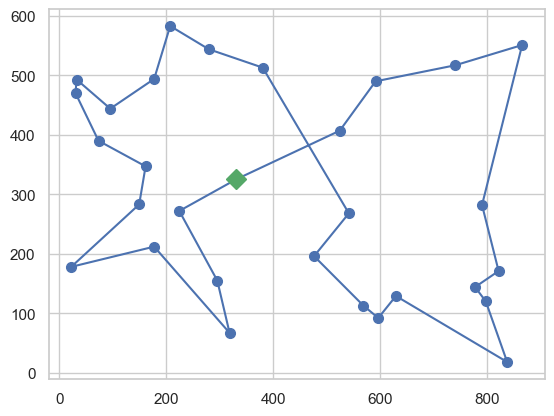

In [303]:
plot_tour(create_tour(best_individual))

## Extra (optional)
It is interesting to assess how the fitness of the population changed as the evolution process took place. We can prepare an `deap.tools.Statistics` instance to specify what data to collect.

In [304]:
fit_stats = tools.Statistics(key=operator.attrgetter("fitness.values"))
fit_stats.register('mean', np.mean)
fit_stats.register('min', np.min)

We are all set now but lets run again the genetic algorithm configured to collect the statistics that we want to gather:

In [305]:
result, log = algorithms.eaSimple(toolbox.population(n=100), toolbox,
                                  cxpb=0.5, mutpb=0.2,
                                  ngen=400, verbose=False,
                                  stats=fit_stats)

Plotting mean and minimium fitness as evolution took place.

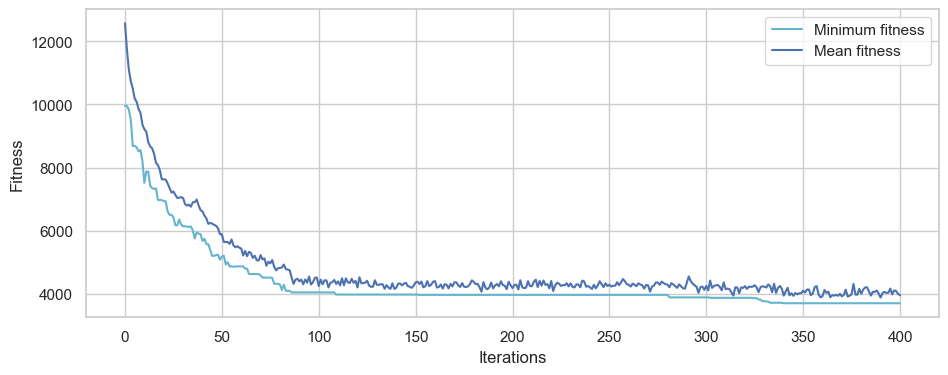

In [306]:
plt.figure(figsize=(11, 4))
plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-')
plt.legend(plots, ('Minimum fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');

### How has the population evolved?

As TSP solutions are easy to visualize, we can plot the individuals of each population as the evolution progressed. We need a new Statistics instance prepared for that.

In [307]:
pop_stats = tools.Statistics(key=np.copy)
pop_stats.register('pop', np.copy) # -- copies the populations themselves
pop_stats.register('fitness', # -- computes and stores the fitnesses
                   lambda x : [evaluation(a) for a in x])

result, log = algorithms.eaSimple(toolbox.population(n=100), toolbox,
                                  cxpb=0.5, mutpb=0.2,
                                  ngen=400, verbose=False,
                                  stats=pop_stats)

Plotting the individuals and their fitness (color-coded)

In [308]:
def plot_population(record, min_fitness, max_fitness):
    '''
    Plots all individuals in a population.
    Darker individuals have a better fitness.
    '''
    pop = record['pop']
    fits = record['fitness']
    index = sorted(range(len(fits)), key=lambda k: fits[k])

    norm=colors.Normalize(vmin=min_fitness,
                          vmax=max_fitness)
    sm = cmx.ScalarMappable(norm=norm,
                            cmap=plt.get_cmap('PuBu'))

    for i in range(len(index)):
        color = sm.to_rgba(max_fitness - fits[index[i]][0])
        plot_tour(create_tour(pop[index[i]]), alpha=0.5, color=color)

In [309]:
min_fitness = np.min(log.select('fitness'))
max_fitness = np.max(log.select('fitness'))

We can now plot the population as the evolutionary process progressed. Darker blue colors imply better fitness.

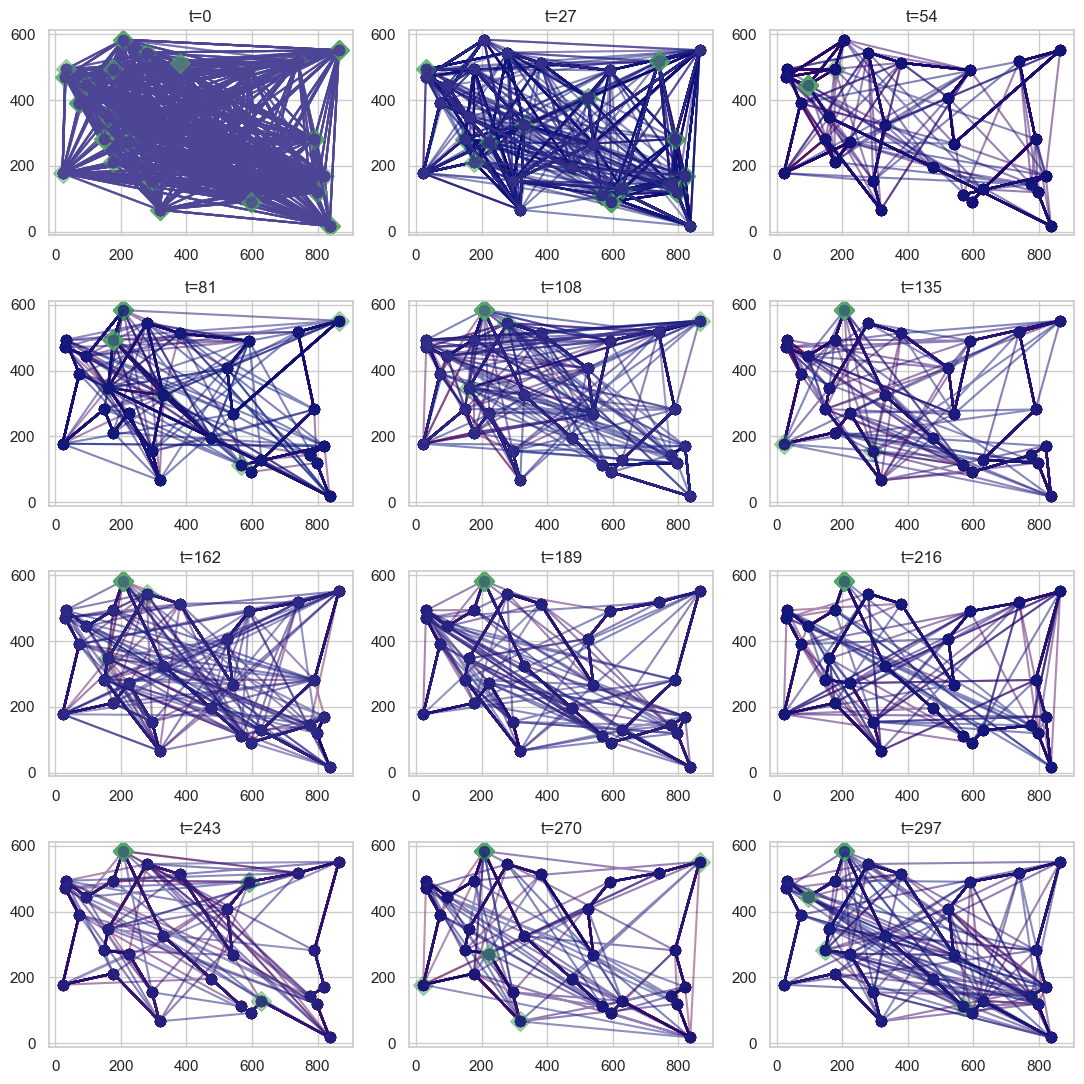

In [310]:
plt.figure(figsize=(11,11))
for i in range(0, 12):
    plt.subplot(4,3,i+1)
    it = int(math.ceil((len(log)-1.)/15))
    plt.title('t=' + str(it*i))
    plot_population(log[it*i], min_fitness, max_fitness)
plt.tight_layout()

The population of the previous experiment can be better appreciated in animated form.

In [311]:
from matplotlib import animation
from IPython.display import HTML

def update_plot_tour(plot, points, alpha=1, color='blue'):
    'A function for updating a plot with an individual'
    X, Y = XY(list(points) + [points[0]])
    plot.set_data(X, Y)
    plot.set_color(color)
    return plot

def init():
    'Initialization of all plots to empty data'
    for p in list(tour_plots):
        p.set_data([], [])
    return tour_plots

def animate(i):
    'Updates all plots to match frame _i_ of the animation'
    pop = log[i]['pop']
    fits = log[i]['fitness']
    index = sorted(range(len(fits)), key=lambda k: fits[k])

    norm=colors.Normalize(vmin=min_fitness,
                          vmax=max_fitness)
    sm = cmx.ScalarMappable(norm=norm,
                            cmap=plt.get_cmap('PuBu'))
    for j in range(len(tour_plots)):
        color = sm.to_rgba(max_fitness - fits[index[j]][0])
        color = (abs(color[0] - 0.7), abs(color[1] - 0.7), abs(color[2] - 0.4), 1)
        update_plot_tour(tour_plots[j],
                         create_tour(pop[index[j]]),
                         alpha=0.5, color=color)
    return tour_plots

The next step takes some time to execute. Use the video controls to see the evolution in animated form.

In [312]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 900), ylim=(0, 600))
tour_plots = [ax.plot([], [], 'bo-', alpha=0.1) for i in range(len(log[0]['pop']))]
tour_plots = [p[0] for p in tour_plots]

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=60, blit=True)
plt.close()

In [313]:
# HTML(anim.to_html5_video())